# Simulating a health insurance claims dataset from KHHEUS survey data
Our final-year university project focused on the profitability and sustainability of micro-health insurance in Kenya. Broadly, micro-insurance refers to insurance products that cover risks at lower premiums, often aimed at low-income earners. Since most insurance companies offering such products in the country were unwilling to provide the sensitive data we needed (aggregate claims, expenses, and premiums), my colleagues and I had to be creative. I came across data collected during the Kenya Household Health Expenditure and Utilization Survey (KHHEUS) conducted in 2018, available on the Kenya National Data Archive (KeNADA) website. I thought it would be interesting to use this data as the basis for simulating a dataset we could then use for our analysis. The process is outlined in this notebook.

## 1. Gathering the required variables from the different files in the website.
The data in the website was in four distinct files:  
i. "2018 khheus_hh_members.sav" : contained information on every individual interviewed during the survey.  
ii. "2018 khheus_c3.sav" : contained information on inpatient visits in the last one year, as provided by the interviewees.  
iii. "section_d1.dta" : contained information on insurance covers, as provided by the interviewees.  
iv. "2018 khheus_c1.sav" : contained information on outpatient visits in the last 4 weeks, as provided by the interviewees.  

In [1]:
# import libraries
import pandas as pd
import pyreadstat
import numpy as np
import numpy as np
np.random.seed(42)
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import kruskal
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import gaussian_kde


C:\Users\tito\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# individual data
individuals_df, meta = pyreadstat.read_sav('2018 khheus_hh_members.sav')

In [3]:
individuals_df.head()

,county,resid,clid,hhid,q1,q3,q3_o,q4,q5,q5_o,...,q74_2,q74_3,q74_4,q74_5,q74_6,q74x,q36_sum,q36_sumannual,annualoop,q60_11_sum
0,5.0,1.0,61.0,1.0,1.0,1.0,,2.0,2.0,,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,5.0,1.0,61.0,1.0,2.0,2.0,,1.0,2.0,,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,5.0,1.0,61.0,1.0,3.0,3.0,,2.0,2.0,,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,5.0,1.0,61.0,1.0,4.0,3.0,,1.0,2.0,,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,5.0,1.0,61.0,1.0,5.0,3.0,,1.0,2.0,,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [4]:
meta.column_names_to_labels

{'county': 'County Code',
 'resid': 'Rural/Urban Residence',
 'clid': 'Cluster number',
 'hhid': 'Household number',
 'q1': 'Household member number',
 'q3': 'Q3. Relationship',
 'q3_o': 'Q3. Relationship Other Specify',
 'q4': 'Q4. Sex',
 'q5': 'Q5. Religion',
 'q5_o': 'Q5. Religion_Other Specify',
 'q6a': 'Q6a. Month',
 'q6a_yr': 'Q6a. Year',
 'q6b': 'Q6b Age in years',
 'q6bx': 'Q6b Age in years',
 'q7': 'Q7. School attendance status',
 'q8': 'Highest level of education reached',
 'q9': 'Q9. Number of years  completed at that level',
 'q10': 'Q10. Current Marital Status',
 'q11': 'Q11. main employment status',
 'q11x': 'Q11. main employment status',
 'q11x2': 'Q11. main employment status',
 'q11_o': 'Q11. main employment status_Other Specify',
 'q12': 'Q12. Main occupation',
 'q13': 'Q13. health status compared to others of his/her age',
 'q14': 'Q14 Smoke - cigarettes, bhangs, Pipe etc',
 'q15a': 'Q15a Hypertension',
 'q15b': 'Q15b Other Cardiac disorders',
 'q15c': 'Q15c Diabetes'

Health insurance is usually purchased at the household level. In the original files, 'clid' represents "a scientifically selected area from an Enumeration Area (EA) for the purposes of carrying out household-based sample surveys," while 'hhid' represents "a person or a group of persons who normally reside together in the same compound or homestead under one or several roofs, are answerable to the same head, and share the same cooking arrangement." The concatenation of these two variables provides a unique way of identifying individual households.

In [5]:
# concatenating cluster_id and household_id into one column
individuals_df['direct_household_id'] = individuals_df['clid'].round().astype(int).astype(str) + "_" + individuals_df['hhid'].round().astype(int).astype(str)

In [6]:
# inpatient data
inpatients_df, meta_2 = pyreadstat.read_sav('2018 khheus_c3.sav')
inpatients_df['type_of_visit'] = "INPATIENT"
inpatients_df['total_inpatient_visits'] = inpatients_df['c00']

In [7]:
inpatients_df.head()

,resid,sup,ra,clid,hhid,q1,q50,s_numb,q51,q52,...,q63new4,q63new5,q63new6,q63new7,q63new8,yy1,q63new10,q60_11_grp,type_of_visit,total_inpatient_visits
0,1.0,2305.0,30523.0,61.0,70.0,5.0,1.0,1.0,1.0,JAMII CLINIC,...,0.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,INPATIENT,1.0
1,1.0,2305.0,30522.0,61.0,75.0,2.0,1.0,1.0,14.0,KING FAHAD HOSPITAL,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,INPATIENT,NaN
2,1.0,2305.0,30524.0,62.0,31.0,4.0,1.0,1.0,60.0,MALINDI HOSPITAL,...,0.0,0.0,0.0,0.0,0.0,1.0,NaN,5.0,INPATIENT,NaN
3,1.0,2305.0,30524.0,62.0,88.0,2.0,1.0,1.0,3.0,MPEKETONI HOSPITAL,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,INPATIENT,NaN
4,1.0,2305.0,30522.0,63.0,28.0,2.0,1.0,1.0,2.0,MPEKETONI HOSPITAL,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,INPATIENT,1.0


In [8]:
meta_2.column_names_to_labels

{'resid': 'Rural/Urban Residence',
 'sup': 'Supervisor',
 'ra': 'Research assistant',
 'clid': 'Cluster number',
 'hhid': 'Household number',
 'q1': 'Household member number',
 'q50': 'Number of Admissions',
 's_numb': 'Visit Number',
 'q51': 'Q51 How long was <Name> admitted',
 'q52': 'Q52 What was the name of the health provider / facility that <Name> was admitted',
 'q53': 'Q53 What was the type and ownership of  health provider / facility that <name> w',
 'q53_o': 'Q53 What was the type and ownership of  health provider / facility that <name> w',
 'q53_o_cou': 'Q53 What was the type and ownership of  health provider / facility that <name> w',
 'q54': 'Q54 Is this the nearest in-patient health facility to your residence?',
 'q55': 'Q55 Who owns the in-patient health facility nearest your residence',
 'q56': 'Q56 What were the three main reasons for by passing the facility nearest to your',
 'q56_1': 'q56. What were the three main reasons for by passing the facility nearest to you',


In [9]:
# insurance data
dta_file_path = r"C:\Users\tito\Downloads\FL\section_d1.dta"
insurance_df = pd.read_stata(dta_file_path)


Given that the monthly premiums paid by each individual are recorded in different columns based on the type of insurance cover they use, I consolidated these columns into a single 'premiums' column that was easier to read and manage. For individuals paying for multiple schemes, their total monthly premium was calculated as the sum of the premiums from the various schemes they subscribed to.

In [10]:
insurance_df.head()

,ra,clid,hhid,d1,q1,q74,q74_o,q75_nhif,q75_o_nhif,q76_nhif,...,q77_empl_inst,q78_empl_inst,q78_o_empl_inst,q75_o,q75_o_spec,q76_o,q76_o_spec,q77_o,q78_o,q78_o_spec
0,30525,61,30,1.0,3,A,,A,,C,...,NaN,,,,,,,NaN,,
1,30525,61,43,1.0,1,A,,A,,C,...,NaN,,,,,,,NaN,,
2,30525,62,3,1.0,1,A,,A,,C,...,NaN,,,,,,,NaN,,
3,30525,62,3,1.0,2,A,,A,,C,...,NaN,,,,,,,NaN,,
4,30523,62,7,1.0,1,A,,A,,C,...,NaN,,,,,,,NaN,,


In [11]:
cols = ['q77_com_bhi', 'q77_cou_is', 'q77_empl_inst', 'q77_nhif', 'q77_o', 'q77_priv_mi']

insurance_df[cols] = insurance_df[cols].fillna(0)
insurance_df[cols] = insurance_df[cols].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)
insurance_df['premiums'] = insurance_df[cols].sum(axis=1)


In [12]:
# outpatient data
outpatients_df, meta_3 = pyreadstat.read_sav('2018 khheus_c1.sav')
outpatients_df['type_of_visit'] = "OUTPATIENT"
outpatients_df['total_outpatient_visits'] = outpatients_df['c00']

In [13]:
outpatients_df.head()

,resid,sup,ra,clid,hhid,q1,c00,s_numb,q25a_2,q25a_3,...,q39new5,q39new6,q39new7,q39new8,q39new9,yy1,q39new10,q36tot_grp,type_of_visit,total_outpatient_visits
0,1.0,2305.0,30523.0,61.0,1.0,1.0,1.0,1.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,OUTPATIENT,1.0
1,1.0,2305.0,30525.0,61.0,10.0,1.0,1.0,1.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,OUTPATIENT,1.0
2,1.0,2305.0,30522.0,61.0,17.0,1.0,1.0,1.0,21.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,OUTPATIENT,1.0
3,1.0,2305.0,30522.0,61.0,17.0,2.0,1.0,1.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,OUTPATIENT,1.0
4,1.0,2305.0,30523.0,61.0,70.0,4.0,1.0,1.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,NaN,3.0,OUTPATIENT,1.0


In [14]:
meta_3.column_names_to_labels

{'resid': 'Rural/Urban Residence',
 'sup': 'Supervisor',
 'ra': 'Research assistant',
 'clid': 'Cluster number',
 'hhid': 'Household number',
 'q1': 'Household member number',
 'c00': 'Total Number of visits',
 's_numb': 'Visit number',
 'q25a_2': 'What were the reasons for seeking care',
 'q25a_3': 'What were the reasons for seeking care',
 'q25a_4': 'What were the reasons for seeking care',
 'q25a_5': 'What were the reasons for seeking care',
 'q25v': 'What were the Reasons for seeking care - Illness - Other',
 'q25b': 'Q25_B. Services',
 'q25b_3': 'What were the reasons for seeking care',
 'q25b_4': 'What were the reasons for seeking care',
 'q25b_5': 'What were the reasons for seeking care',
 'q25b_6': 'What were the reasons for seeking care',
 'q25w': 'What were the Reasons for seeking care - Illness - Other',
 'q25b_o': 'Q25_Services_others_specified',
 'q27_o': 'Q27a. type of the health facility / provider_Other specify',
 'q28': 'Q28. Is this the nearest facility/health provide

Here, my aim was to consolidate all the data on every individual who had either been to the hospital as an inpatient in the past year (at the time of the interview) or, as an outpatient in the past four weeks (also at the time of the interview).

In [15]:
# merging dataframes
treatments_df = pd.concat([outpatients_df, inpatients_df], ignore_index=True)
mega_df = pd.merge(treatments_df, insurance_df, on=['clid', 'hhid', 'q1'], how='left')
mega_df = pd.merge(mega_df, individuals_df, on=['clid', 'hhid', 'q1'], how='left')


In [16]:
mega_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30818 entries, 0 to 30817
Columns: 840 entries, resid_x to direct_household_id
dtypes: float32(1), float64(586), object(253)
memory usage: 197.4+ MB


In [17]:
# selecting relevant columns
columns_to_keep = [
    "county_x", 
    "resid_x", 
    "clid", 
    "hhid", 
    "q1", 
    "q4_x", 
    "q6bx_x", 
    "q8_x", 
    "q10_x", 
    "q12_x", 
    "wealth_index1_y", 
    "premiums", 
    "total_inpatient_visits",
    "total_outpatient_visits", 
    "q60_11", 
    "q52", 
    "q36_7_overl", 
    "q26",
    "type_of_visit",     
     'q61_o',
     'q37_o',
     'q25a',
     'q25b',
     'q58a',
     'q58b'
]
mega_df = mega_df[columns_to_keep]
mega_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30818 entries, 0 to 30817
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   county_x                 30818 non-null  float64
 1   resid_x                  30818 non-null  float64
 2   clid                     30818 non-null  float64
 3   hhid                     30818 non-null  float64
 4   q1                       30818 non-null  float64
 5   q4_x                     30815 non-null  float64
 6   q6bx_x                   30815 non-null  float64
 7   q8_x                     30815 non-null  float64
 8   q10_x                    30815 non-null  float64
 9   q12_x                    30818 non-null  object 
 10  wealth_index1_y          30815 non-null  float64
 11  premiums                 5618 non-null   float64
 12  total_inpatient_visits   1849 non-null   float64
 13  total_outpatient_visits  25996 non-null  float64
 14  q60_11                

I consolidated several columns to avoid redundancies based on the type of hospital visit the patient had. For instance, the column 'q26' initially represented the hospital an outpatient visited; however, it was left blank for inpatient records.

In [18]:
# consolidating columns
mega_df['service'] = mega_df['q25b'].combine_first(mega_df['q58b'])
mega_df['hospital'] = mega_df['q26'].combine_first(mega_df['q52'])
mega_df['illness'] = mega_df['q25a'].combine_first(mega_df['q58a'])
mega_df['payment_method'] = mega_df['q37_o'].combine_first(mega_df['q61_o'])

columns_to_drop = ['q25b','q26', 'q25a', 'q37_o', 'q58b', 'q52', 'q58a', 'q61_o' ]
mega_df = mega_df.drop(columns_to_drop,axis=1)


In [19]:
# renaming columns
rename_dict = {
    "county_x": "county",
    "resid_x": "residence",
    "clid": "cluster_id",
    "hhid": "household_id",
    "q1": "individual_id",
    "q4_x": "sex",
    "q6bx_x": "age_in_years",
    "q8_x": "education_level",
    "q10_x": "marriage_status",
    "q12_x": "occupation",
    "wealth_index1_y": "wealth_index",
    "premiums": "monthly_premium",
    "c00_x": "number_of_visits_in_last_year",
    "q36_7_overl" : "outpatient_medical_costs",
    "q60_11" : "inpatient_medical_costs"
}
mega_df = mega_df.rename(rename_dict, axis=1)

In [20]:
# concatenating cluster_id and household_id into one column
mega_df['direct_household_id'] = mega_df['cluster_id'].round().astype(int).astype(str) + "_" + mega_df['household_id'].round().astype(int).astype(str)


In [21]:
mega_df.head()

,county,residence,cluster_id,household_id,individual_id,sex,age_in_years,education_level,marriage_status,occupation,...,total_inpatient_visits,total_outpatient_visits,inpatient_medical_costs,outpatient_medical_costs,type_of_visit,service,hospital,illness,payment_method,direct_household_id
0,5.0,1.0,61.0,1.0,1.0,2.0,44.0,3.0,2.0,ECD TEACHER,...,NaN,1.0,NaN,NaN,OUTPATIENT,U,HINDI MAGOGONI DISPENSARY,S,,61_1
1,5.0,1.0,61.0,10.0,1.0,1.0,58.0,3.0,2.0,GARDEN FARMER,...,NaN,1.0,NaN,NaN,OUTPATIENT,AL,HINDI HEALTH CENTRE,I,,61_10
2,5.0,1.0,61.0,17.0,1.0,1.0,41.0,2.0,2.0,SHOP KEEPER AND HOTELIER,...,NaN,1.0,NaN,NaN,OUTPATIENT,SO,HINDI HEALTH CENTRE,AS,,61_17
3,5.0,1.0,61.0,17.0,2.0,2.0,28.0,2.0,2.0,WORKING IN A HOTEL,...,NaN,1.0,NaN,NaN,OUTPATIENT,T,BLADDER BACTERIA,D,NO MONEY GIVEN OUT,61_17
4,5.0,1.0,61.0,70.0,4.0,2.0,8.0,1.0,5.0,,...,NaN,1.0,NaN,300.0,OUTPATIENT,U,HINDI DISPENSARY,S,,61_70


In [22]:
mega_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30818 entries, 0 to 30817
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   county                    30818 non-null  float64
 1   residence                 30818 non-null  float64
 2   cluster_id                30818 non-null  float64
 3   household_id              30818 non-null  float64
 4   individual_id             30818 non-null  float64
 5   sex                       30815 non-null  float64
 6   age_in_years              30815 non-null  float64
 7   education_level           30815 non-null  float64
 8   marriage_status           30815 non-null  float64
 9   occupation                30818 non-null  object 
 10  wealth_index              30815 non-null  float64
 11  monthly_premium           5618 non-null   float64
 12  total_inpatient_visits    1849 non-null   float64
 13  total_outpatient_visits   25996 non-null  float64
 14  inpati

## 2. Missing and extreme values.

First, I examined the extreme values in the two outpatient columns: outpatient costs and visits. This was important because extreme values, particularly in these  columns where data was collected only for the last month, could significantly skew annualized medical cost estimates if extrapolated. To mitigate this, I set a threshold at the 99th percentile and dropped records with values exceeding that limit.



In [23]:
print(f"99th percentile for outpatient medical costs: {mega_df['outpatient_medical_costs'].quantile(0.99)}")
print(f"99th percentile for outpatient visits: {mega_df['total_outpatient_visits'].quantile(0.99)}")

99th percentile for outpatient medical costs: 22049.999999999272
99th percentile for outpatient visits: 4.0


In [24]:
mega_df.drop(mega_df[mega_df['outpatient_medical_costs'] > 22000].index, inplace=True)
mega_df.drop(mega_df[mega_df['total_outpatient_visits'] > 4].index, inplace=True)

Next, I chose to impute missing medical costs using averages based on illness and the type of  hospital service the patient recieved. For this to be justified, there needed to be significant changes in medical costs due to illness and service. Statistically, this is done through independence tests, which can either be parametric - those that assume the distribution (typically Normal) of the variable in question - or, non-parametric. QQ plots of medical costs suggested that the costs were not normally distributed, and so non-parametric methods were better suited. 

The Kruskal - Wallis test, the non-parametric equivalent of the ANOVA test, examines independence by testing whether there are a statistically significant differences between group medians. The results indicated that both inpatient and outpatient medical costs varied significantly by the type of service recieved and by the illness of the patient,therefore justifying the imputation method.

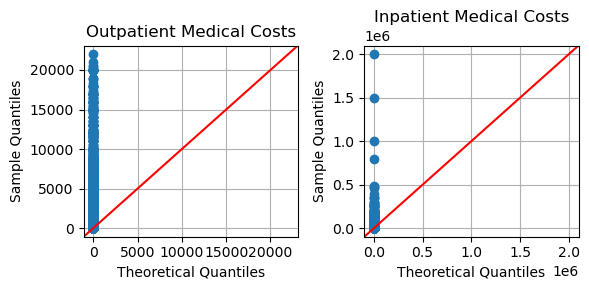

In [25]:
var_1 = mega_df['outpatient_medical_costs']
var_2 = mega_df['inpatient_medical_costs']

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Q-Q plot for outpatient
sm.qqplot(var_1, line='45', ax=axes[0])
axes[0].set_title('Outpatient Medical Costs')
axes[0].grid(True)

# Q-Q plot for inpatient
sm.qqplot(var_2, line='45', ax=axes[1])
axes[1].set_title('Inpatient Medical Costs')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [26]:

factors = ['illness', 'service']
costs = ['outpatient_medical_costs', 'inpatient_medical_costs']

results = []

# Loop through each factor and cost combination
for cost_var in costs:
    for factor in factors:
        # Drop NaNs for current factor and cost variable
        subset = mega_df[[factor, cost_var]].dropna()

        # Create groups based on factor categories
        groups = [subset[subset[factor] == val][cost_var] for val in subset[factor].unique()]

        # Run Kruskal-Wallis test
        if len(groups) > 1:
            stat, p = kruskal(*groups)
        else:
            stat, p = None, None  

        results.append({
            'Cost Variable': cost_var,
            'Factor': factor,
            'p-value': p,
            'Significant (p < 0.05)': p is not None and p < 0.05
        })

# Create summary DataFrame
summary_df = pd.DataFrame(results)

print(summary_df.to_string(index=False))

           Cost Variable  Factor       p-value  Significant (p < 0.05)
outpatient_medical_costs illness 1.162073e-145                    True
outpatient_medical_costs service  2.230283e-75                    True
 inpatient_medical_costs illness  2.179936e-50                    True
 inpatient_medical_costs service  2.138652e-84                    True


In [27]:
# Imputing missing medical costs by looking up averages based on illness, service and type of visit
cost_lookup_out = mega_df.groupby(['illness', 'service'])['outpatient_medical_costs'].mean().reset_index()
cost_lookup_in = mega_df.groupby(['illness', 'service'])['inpatient_medical_costs'].mean().reset_index()

mega_df = mega_df.merge(
    cost_lookup_out,
    on=['illness', 'service'],
    how='left',
    suffixes=('', '_out_imputed')
)

mega_df = mega_df.merge(
    cost_lookup_in,
    on=['illness', 'service'],
    how='left',
    suffixes=('', '_in_imputed')
)

mega_df['outpatient_medical_costs'] = mega_df['outpatient_medical_costs'].combine_first(mega_df['outpatient_medical_costs_out_imputed'])
mega_df['inpatient_medical_costs'] = mega_df['inpatient_medical_costs'].combine_first(mega_df['inpatient_medical_costs_in_imputed'])

mega_df.drop(columns=['outpatient_medical_costs_out_imputed', 'inpatient_medical_costs_in_imputed'], inplace=True)



In [28]:
mega_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30690 entries, 0 to 30689
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   county                    30690 non-null  float64
 1   residence                 30690 non-null  float64
 2   cluster_id                30690 non-null  float64
 3   household_id              30690 non-null  float64
 4   individual_id             30690 non-null  float64
 5   sex                       30687 non-null  float64
 6   age_in_years              30687 non-null  float64
 7   education_level           30687 non-null  float64
 8   marriage_status           30687 non-null  float64
 9   occupation                30690 non-null  object 
 10  wealth_index              30687 non-null  float64
 11  monthly_premium           5580 non-null   float64
 12  total_inpatient_visits    1849 non-null   float64
 13  total_outpatient_visits   25868 non-null  float64
 14  inpati

In [29]:
# fill blanks with NaN
mega_df.fillna(np.nan, inplace= True)

## 3. Aggregation by household and annualizing outpatient costs

I aggregated all costs by household using the direct_household_id variable, which was a concatenation of cluster and household IDs. This approach was appropriate since, as discussed earlier, health insurance is primarily obtained at the household level.

In [30]:
# grouping by household id
agg_df = mega_df.groupby('direct_household_id').agg({
    'outpatient_medical_costs': 'sum',
    'inpatient_medical_costs' : 'sum',
    'total_inpatient_visits': 'sum',
    'total_outpatient_visits' : 'sum',
    'wealth_index': 'mean',
    'monthly_premium': 'mean',
    'individual_id': pd.Series.nunique
})


In [31]:
# renaming columns and resetting index
name_dict = {
    "direct_household_id": "household",
    "wealth_index" : "household_wealth_index",
    "monthly_premium" : "total_monthly_household_premium",
    "individual_id" : "total_individuals_in_household",
    "inpatient_medical_costs" : "annual_inpatient_medical_costs",
    "total_inpatient_visits" : "annual_inpatient_visits"
    }
agg_df = agg_df.rename(name_dict, axis=1)
agg_df = agg_df.reset_index()

In [32]:
agg_df.head()

,direct_household_id,outpatient_medical_costs,annual_inpatient_medical_costs,annual_inpatient_visits,total_outpatient_visits,household_wealth_index,total_monthly_household_premium,total_individuals_in_household
0,100_112,1638.957724,61562.54717,0.0,1.0,2.0,NaN,1
1,100_30,1514.385965,0.00000,0.0,1.0,1.0,NaN,1
2,100_35,816.263538,0.00000,0.0,1.0,1.0,NaN,1
3,100_40,2516.263538,0.00000,0.0,2.0,2.0,NaN,2
4,100_48,9300.000000,0.00000,0.0,4.0,4.0,NaN,1


In [33]:
agg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16399 entries, 0 to 16398
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   direct_household_id              16399 non-null  object 
 1   outpatient_medical_costs         16399 non-null  float64
 2   annual_inpatient_medical_costs   16399 non-null  float64
 3   annual_inpatient_visits          16399 non-null  float64
 4   total_outpatient_visits          16399 non-null  float64
 5   household_wealth_index           16397 non-null  float64
 6   total_monthly_household_premium  3452 non-null   float64
 7   total_individuals_in_household   16399 non-null  int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 1.0+ MB


It was evident that some, about 48% of the surveyed households in the 'individuals_df' dataframe, did not have matching medical records. This could be due to errors during the process or, simply, because they did not have any hospital visits during the stipulated time periods. To create a realistic dataset for medical insurance—where a policy may not always result in claims over a given period—these 'zero' claims were needed. Therefore, I identified the missing households and incorporated their details with those that had medical records.

In [34]:
print(f"Number of households with medical information: {len(agg_df['direct_household_id'])}")
print(f"Total number of households surveyed: {len(individuals_df['direct_household_id'].unique())}")


Number of households with medical information: 16399
Total number of households surveyed: 31655


In [35]:
# households without medical payments
list_ids = list(agg_df['direct_household_id'])

cols = ['direct_household_id', 'household_wealth_index',
        'total_monthly_household_premium', 'total_individuals_in_household']
agg_df2 = pd.DataFrame(columns=cols)


for _, row in individuals_df.iterrows():
    if row['direct_household_id'] not in list_ids:
        new_row = pd.DataFrame([{
            'direct_household_id': row['direct_household_id'],
            'outpatient_medical_costs': 0,
            'annual_inpatient_medical_costs': 0,
            'annual_inpatient_visits': 0,
            'total_outpatient_visits': 0,
            'household_wealth_index': row['wealth_index1'],
            'total_monthly_household_premium': 0,
            'total_individuals_in_household': row['hhsize_group']
        }])

        agg_df2 = pd.concat([agg_df2, new_row], ignore_index=True)
        list_ids.append(row['direct_household_id'])


In [36]:
# joining the two dataframes
final_df = pd.concat([agg_df,agg_df2])

# dropping the two records without wealth index values
final_df = final_df.dropna(subset=['household_wealth_index'])

In [37]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31655 entries, 0 to 15257
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   direct_household_id              31655 non-null  object 
 1   outpatient_medical_costs         31655 non-null  float64
 2   annual_inpatient_medical_costs   31655 non-null  float64
 3   annual_inpatient_visits          31655 non-null  float64
 4   total_outpatient_visits          31655 non-null  float64
 5   household_wealth_index           31655 non-null  float64
 6   total_monthly_household_premium  18710 non-null  object 
 7   total_individuals_in_household   31655 non-null  float64
dtypes: float64(6), object(2)
memory usage: 2.2+ MB


In [38]:
final_df.head()

,direct_household_id,outpatient_medical_costs,annual_inpatient_medical_costs,annual_inpatient_visits,total_outpatient_visits,household_wealth_index,total_monthly_household_premium,total_individuals_in_household
0,100_112,1638.957724,61562.54717,0.0,1.0,2.0,NaN,1.0
1,100_30,1514.385965,0.00000,0.0,1.0,1.0,NaN,1.0
2,100_35,816.263538,0.00000,0.0,1.0,1.0,NaN,1.0
3,100_40,2516.263538,0.00000,0.0,2.0,2.0,NaN,2.0
4,100_48,9300.000000,0.00000,0.0,4.0,4.0,NaN,1.0


To annualize outpatient medical visits and costs, I first grouped households based on their wealth index and the number of individuals in the household. I then fitted joint kernel density estimates within each group, from which I sampled the preceding 11 months of costs and visits.

To justify this approach statistically, I needed to confirm that outpatient medical costs and visits were significantly influenced by household wealth and size. This assumption is also intuitive, as wealthier and larger households are expected to visit healthcare facilities more frequently and incur higher costs. The Kruskal–Wallis test results supported this claim.

In [39]:

factors = ['household_wealth_index', 'total_individuals_in_household']
costs = ['outpatient_medical_costs','total_outpatient_visits']

results = []

# Loop through each factor and cost combination
for cost_var in costs:
    for factor in factors:
        # Drop NaNs for current factor and cost variable
        subset = final_df[[factor, cost_var]].dropna()

        # Create groups based on factor categories
        groups = [subset[subset[factor] == val][cost_var] for val in subset[factor].unique()]

        # Run Kruskal-Wallis test
        if len(groups) > 1:
            stat, p = kruskal(*groups)
        else:
            stat, p = None, None  

        results.append({
            'Cost Variable': cost_var,
            'Factor': factor,
            'p-value': p,
            'Significant (p < 0.05)': p is not None and p < 0.05
        })

# Create summary DataFrame
summary_df = pd.DataFrame(results)

print(summary_df.to_string(index=False))

           Cost Variable                         Factor      p-value  Significant (p < 0.05)
outpatient_medical_costs         household_wealth_index 7.477441e-10                    True
outpatient_medical_costs total_individuals_in_household 0.000000e+00                    True
 total_outpatient_visits         household_wealth_index 1.234937e-15                    True
 total_outpatient_visits total_individuals_in_household 0.000000e+00                    True


In [40]:
# Ensure household size is binned correctly
final_df['total_individuals_in_household'] = final_df['total_individuals_in_household'].apply(
    lambda x: '3 or more' if x > 3 else str(int(x))
)

In [41]:
# Create the stratum key
final_df['stratum'] = list(zip(
    final_df['household_wealth_index'],
    final_df['total_individuals_in_household']
))

In [42]:
# strata sizes
print(final_df['stratum'].value_counts())

stratum
(4.0, 1)            4077
(5.0, 1)            3584
(3.0, 1)            3421
(1.0, 1)            3129
(2.0, 1)            3021
(1.0, 2)            2214
(2.0, 2)            2132
(3.0, 2)            2070
(4.0, 2)            2011
(5.0, 2)            1533
(1.0, 3)            1107
(2.0, 3)             924
(3.0, 3)             806
(4.0, 3)             605
(5.0, 3)             335
(1.0, 3 or more)     168
(2.0, 3 or more)     162
(3.0, 3 or more)     161
(4.0, 3 or more)     128
(5.0, 3 or more)      67
Name: count, dtype: int64


The number of hospital visits in a month and the corresponding medical bill are dependent variables. Because of this dependency, I chose to fit joint Kernel Density Estimates (KDEs) for each stratum, then sampled 11 times to generate annualized data for each individual. For example, if Household 1 contained 2 members and belonged to the 4th wealth quantile, I sampled 11 times from the KDE corresponding to the stratum (2.0, 4) to simulate medical costs and visits for the preceding 11 months. I then aggregated these simulated values with the observed data from the last month to estimate each household’s annual medical usage and expenditure.

Kernel Density Estimation (KDE) is a non-parametric method used to to estimate the probability density function (PDF) of a random variable. Given a set of observed values  X1 to Xn, a 'kernel' distribution (in this case I used the normal distribution) is centered at each data point (X value). The estimated probability density at any point y is then given by averaging the corresponding densities of the kernel distributions.
$$
\hat{f}_h(x) = \frac{1}{n h} \sum_{i=1}^n K\left( \frac{x - X_i}{h} \right)
$$

where:
- $\hat{f}_h(x)$ is the estimated probability density at point $x$ 
- $K$ is the kernel function (e.g., the standard normal PDF),
- $h$ is the bandwidth (smoothing parameter),
- $n$ is the number of data points.


In [43]:
stratum_kdes = {}
annual_costs = []
annual_visits = []

# Fit 2D KDE per stratum
for stratum, group in final_df.groupby('stratum'):
    joint_data = group[['outpatient_medical_costs', 'total_outpatient_visits']].dropna().T
    if joint_data.shape[1] > 2:
        stratum_kdes[stratum] = gaussian_kde(joint_data)

# Sampling
for _, row in final_df.iterrows():
    stratum = row['stratum']
    if stratum in stratum_kdes:
        joint_kde = stratum_kdes[stratum]
        samples = joint_kde.resample(11)
        
        # Add original data
        samples = np.column_stack((samples, [row['outpatient_medical_costs'], row['total_outpatient_visits']]))
        
        sampled_costs = samples[0]
        sampled_visits = samples[1]

        # Clean up values
        sampled_costs = np.clip(sampled_costs, a_min=0, a_max=None)
        sampled_visits = np.clip(sampled_visits, a_min=0, a_max=None)
        sampled_visits = np.round(sampled_visits)

        annual_costs.append(sampled_costs.sum())
        annual_visits.append(sampled_visits.sum())
        
final_df['annual_outpatient_medical_costs'] = annual_costs
final_df['annual_outpatient_visits'] = annual_visits

In [44]:
final_df = final_df.drop(['outpatient_medical_costs', 'total_outpatient_visits'],axis=1)
final_df.head()

,direct_household_id,annual_inpatient_medical_costs,annual_inpatient_visits,household_wealth_index,total_monthly_household_premium,total_individuals_in_household,stratum,annual_outpatient_medical_costs,annual_outpatient_visits
0,100_112,61562.54717,0.0,2.0,NaN,1,"(2.0, 1)",15798.477223,10.0
1,100_30,0.00000,0.0,1.0,NaN,1,"(1.0, 1)",16739.046216,5.0
2,100_35,0.00000,0.0,1.0,NaN,1,"(1.0, 1)",10116.024283,14.0
3,100_40,0.00000,0.0,2.0,NaN,2,"(2.0, 2)",13351.221708,20.0
4,100_48,0.00000,0.0,4.0,NaN,1,"(4.0, 1)",13471.200204,12.0


## 4. Ten-year claims simulation
 

In [45]:
# total claims and visits
final_df['total_medical_expenditure'] = final_df['annual_inpatient_medical_costs'] + final_df['annual_outpatient_medical_costs']
final_df['total_medical_claims'] = final_df['annual_inpatient_visits'] + final_df['annual_outpatient_visits']


In [46]:
# dropping columns
data_df = final_df.copy()
data_df.drop(['annual_inpatient_medical_costs','annual_inpatient_visits','annual_outpatient_medical_costs','annual_outpatient_visits'], axis= 1, inplace=True)
data_df = data_df[~((data_df['total_medical_expenditure'] > 0) & (data_df['total_medical_claims'] < 1))]

In [47]:
data_df.head()

,direct_household_id,household_wealth_index,total_monthly_household_premium,total_individuals_in_household,stratum,total_medical_expenditure,total_medical_claims
0,100_112,2.0,NaN,1,"(2.0, 1)",77361.024393,10.0
1,100_30,1.0,NaN,1,"(1.0, 1)",16739.046216,5.0
2,100_35,1.0,NaN,1,"(1.0, 1)",10116.024283,14.0
3,100_40,2.0,NaN,2,"(2.0, 2)",13351.221708,20.0
4,100_48,4.0,NaN,1,"(4.0, 1)",13471.200204,12.0


In [48]:
# summary statistics
print(data_df['total_medical_expenditure'].describe())
print(data_df['total_medical_claims'].describe())

count    3.164100e+04
mean     2.447861e+04
std      3.624852e+04
min      0.000000e+00
25%      8.122150e+03
50%      1.278969e+04
75%      2.467532e+04
max      2.013527e+06
Name: total_medical_expenditure, dtype: float64
count    31641.000000
mean        13.645334
std         12.595150
min          1.000000
25%          7.000000
50%         10.000000
75%         16.000000
max        138.000000
Name: total_medical_claims, dtype: float64


Similar to the previous step, I generated 10 years of medical expenditure data by fitting joint KDEs to each stratum and sampling 10 times. This approach assumes that medical expenditure patterns, household composition and financial status remain constant over the 10-year period.

In [49]:
stratum_kdes = {}
years = list(range(1, 11))
simulated_data = []
# Fit 2D KDE per stratum
for stratum, group in data_df.groupby('stratum'):
    joint_data = group[['total_medical_expenditure', 'total_medical_claims']].dropna().T
    if joint_data.shape[1] > 2:
        stratum_kdes[stratum] = gaussian_kde(joint_data)

# Sampling
for _, row in data_df.iterrows():
    stratum = row['stratum']
    if stratum in stratum_kdes:
        joint_kde = stratum_kdes[stratum]
        for year in years:
            sample = joint_kde.resample(1)
            sampled_amount = sample[0].item()
            sampled_number = sample[1].item()
            sampled_amount = np.clip(sampled_amount, a_min=0, a_max=None)
            sampled_number = np.clip(sampled_number, a_min=0, a_max=None)
            sampled_number = np.round(sampled_number)
            simulated_data.append({
                'household_id': row['direct_household_id'],
                'year': year,
                'total_individuals_in_household': row['total_individuals_in_household'],
                'wealth_quantile': row['household_wealth_index'],
                'simulated_medical_costs': sampled_amount,
                'number_of_claims': sampled_number})

In [50]:
# list to dataframe
sim_df = pd.DataFrame(simulated_data)


In [57]:
# dropping zero claims
sim_df = sim_df[(sim_df['simulated_medical_costs'] > 0) & (sim_df['number_of_claims'] > 0)]

In [58]:
sim_df.head(10)

,household_id,year,total_individuals_in_household,wealth_quantile,simulated_medical_costs,number_of_claims
0,100_112,1,1,2.0,13172.241021,24.0
2,100_112,3,1,2.0,18848.101306,19.0
3,100_112,4,1,2.0,87715.711860,6.0
5,100_112,6,1,2.0,29155.427959,16.0
6,100_112,7,1,2.0,56360.452593,5.0
7,100_112,8,1,2.0,33591.626828,8.0
8,100_112,9,1,2.0,15389.156436,20.0
9,100_112,10,1,2.0,19388.387904,19.0
11,100_30,2,1,1.0,30647.869502,6.0
12,100_30,3,1,1.0,14699.672984,18.0


In [59]:
sim_df.to_csv('annual_claims_per_household.csv',index = False)

In [60]:
agg_simmed = sim_df.groupby('year')[['simulated_medical_costs', 'number_of_claims']].sum()

In [61]:
agg_simmed

,simulated_medical_costs,number_of_claims
year,,
1,7.815613e+08,404414.0
2,7.881151e+08,405327.0
3,7.906745e+08,404321.0
4,7.994663e+08,406349.0
5,7.944947e+08,405448.0
6,7.925488e+08,406320.0
7,7.842513e+08,405168.0
8,7.917090e+08,405110.0
9,7.948196e+08,404524.0
